## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

Ссылки на датасеты удалены из проекта, чтобы не нарушать авторские права Яндекса.

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col='datetime', parse_dates=True)
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Для того чтобы работать с датой и временем в pandas, нужно корректно изменить тип данных соответствующего столбца с *object* на *datetime64*, делаем это при чтении с помощью параметра 'parse_dates' и сразу устанавливаем дату индексом датафрейма с использованием 'index_col'.

In [3]:
data.index.is_monotonic

True

Проверили, в хронологическом ли порядке расположены даты и время - видим, что порядок соблюдён.

In [5]:
data = data.resample('1H').sum()

Выполнили ресемплирование данных по одному часу, для вычисления агрегированных значений ряда использовали сумму.

# 2. Анализ

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


У нас есть данные о суммарном количестве заказов такси в аэропортах за каждый час в период с 1 марта по 31 августа 2018 года.

In [7]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


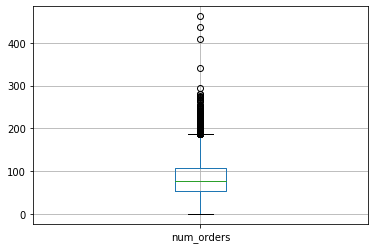

In [8]:
data.boxplot()

Видим, что в данных есть выбросы: 75% значений значительно меньше максимального числа заказов. Попробуем понять, с чем связаны пиковые нагрузки в такси. Увидеть циклично повторяющиеся закономерности во временном ряду мы можем только, если цикл меньше года, поскольку у нас есть данные только за один год.

Разложим временной ряд на три составляющие: тренд, сезонность и остаток.

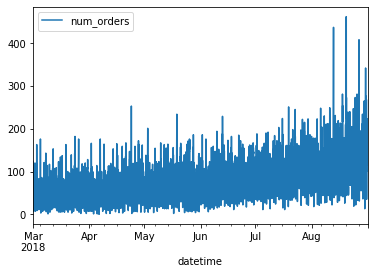

In [9]:
data.plot()

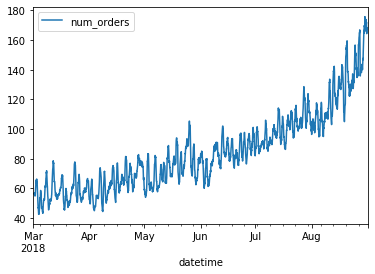

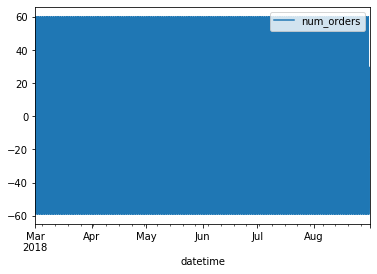

In [10]:
decomposed = seasonal_decompose(data)
decomposed.trend.plot()
decomposed.seasonal.plot()

Видим, что увеличение числа заказов к лету — это тренд. Возможно, если бы мы анализировали эти данные в масштабе нескольких лет, рост числа заказов к лету стал бы уже сезонным изменением. Попробуем посмотреть, есть ли сезонность в рамках месяца.

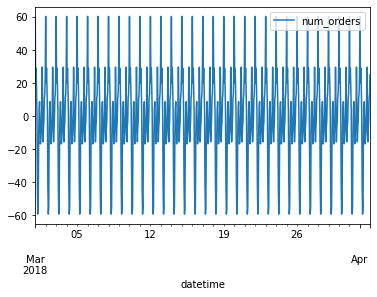

In [11]:
decomposed.seasonal['2018-03-01':'2018-04-01'].plot()

Во временном ряду есть циклично повторяющиеся закономерности, такие сезонные условия добавляются для каждого месяца в каждом году, но они сложно интерпретируемы, посмотрим в рамках дня.

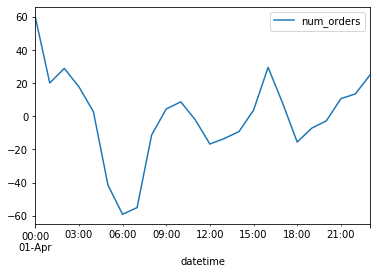

In [12]:
decomposed.seasonal['2018-04-01':'2018-04-01'].plot()

Также видим, что в рамках дня присутствует цикличность: пиковые значения наблюдаются в полночь, когда сложно добраться до города из аэропорта на общественном транспорте, но, возможно, это не связанно. Иногда пики компенсируются трендом и становятся не заметны. Посмотрим на остаток - компоненту, которая не объясняется трендом и сезонностью. Пошумим, другими словами.

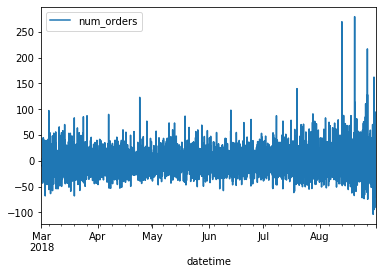

In [13]:
decomposed.resid.plot()

# 3. Обучение

In [14]:
# зафиксируем значение параметра random_state, чтобы результаты нашей работы были воспроизводимы
state = 12345

Создадим признаки: 

Тренды и сезонность привязаны к датам, индексы датафрейма уже содержат нужную информацию, осталось лишь представить её как отдельные столбцы - получим календарные признаки.

Предыдущие значения временного ряда подскажут, будет ли число заказов расти или уменьшаться. Получим отстающие значения функцией *shift()* - получим lag features.

Также добавим скользящее среднее, которое как признак задаёт общий тренд временного ряда. Скользящее среднее учитывает текущее значение ряда, что некорректно: целевой признак утечет - поэтому воспользуемся функцией shift.

Количество отстающих признаков и окно для скользящего среднего возьмем равным 24, поскольку в рамках дня наблюдается цикличность.

In [27]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for i in range(1, max_lag+1):
        data['lag_{}'.format(i)] = data['num_orders'].shift(i)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
make_features(data, 24, 24)
data.dropna(inplace=True)

Разделим данные на обучающую (*train*) и тестовую (*test*) выборки. Перемешивать выборки в задаче прогнозирования временного ряда нельзя. Данные обучающей выборки должны предшествовать данным тестовой. Иначе тестирование модели будет некорректным: модель не должна обучаться на данных из будущего, поэтому укажем аргумент *shuffle = False*, чтобы разделить данные корректно. Сделаем тестовую выборку размером 10% от исходных данных.

In [17]:
target = data['num_orders']
features = data.drop('num_orders', axis=1)
target_train, target_test, features_train, features_test = train_test_split(
    target, features, test_size=0.1, shuffle=False)

Обучим 4 модели:

- Линейную регрессию
- Случайный лес
- Модель градиентного бустинга с использованием библиотеки CatBoost
- Модель градиентного бустинга с использованием библиотеки LightGBM

Для каждой попробуем различные гиперпараметры.

In [19]:
lr = LinearRegression()
lr.fit(features_train, target_train)
predictions = lr.predict(features_test)

В случае временных рядов кросс-валидация не является тривиальной. Мы не можем выбрать случайные фолды, потому что нет смысла использовать значения из будущего для прогнозирования значений в прошлом. Проще говоря, мы не хотим заглядывать в будущее при обучении нашей модели. Между наблюдениями существует временная зависимость, и мы должны сохранять эту связь во время тестирования, с этим нам поможет параметр cv=TimeSeriesSplit(n_splits=3).

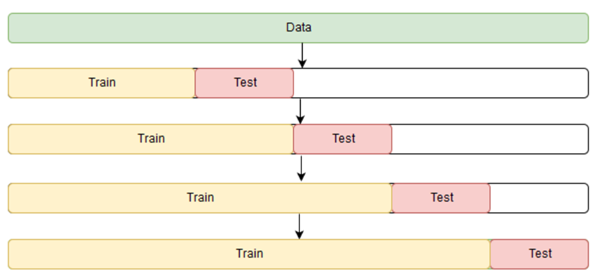

In [20]:
%%time

grid_params_rf = {'n_estimators': range(1,30,1)}

rf = RandomizedSearchCV(RandomForestRegressor(), grid_params_rf,
                  cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_squared_error', n_iter=20, random_state=state)
rf.fit(features_train, target_train)

CPU times: user 31.4 s, sys: 34.5 ms, total: 31.4 s
Wall time: 32 s


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
                   error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,

In [21]:
grid = {'learning_rate': [0.03, 0.1],
        'depth': [5, 10]}

In [22]:
%%time

cat_boost = CatBoostRegressor(iterations=100)
cat_boost_search = cat_boost.randomized_search(grid,
                                               cv=TimeSeriesSplit(n_splits=3),
                                               X=features_train,
                                               y=target_train)

0:	loss: 40.5692820	best: 40.5692820 (0)	total: 3.18s	remaining: 9.55s
1:	loss: 34.7888232	best: 34.7888232 (1)	total: 5.07s	remaining: 5.07s
2:	loss: 44.2093119	best: 34.7888232 (1)	total: 21.4s	remaining: 7.12s
3:	loss: 38.7128191	best: 34.7888232 (1)	total: 37.9s	remaining: 0us
Estimating final quality...
CPU times: user 43.1 s, sys: 2.9 s, total: 46 s
Wall time: 54.1 s


In [23]:
%%time

lgbm = LGBMRegressor()
lgbm_search = RandomizedSearchCV(lgbm, grid,
                  cv=TimeSeriesSplit(n_splits=3), n_iter=2, random_state=state)
lgbm_search.fit(features_train, target_train)

CPU times: user 12 s, sys: 147 ms, total: 12.1 s
Wall time: 12.2 s


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
                   error_score='raise-deprecating',
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random_state=None,
                                           reg_alpha=0.0, reg_lambda=0.0,
                                           silent=True, subsample=1.0,
                                   

# 4. Тестирование

Спрогнозируем временной ряд без обучения, предсказывая все значения тестовой выборки константой — последним значением ряда из тренировочной выборки, чтобы было с чем сравнить значения, полученные при обучении моделей.

In [24]:
dummy = DummyRegressor(strategy='constant', constant=target_train.iloc[-1])
dummy.fit(features_train, target_train)

DummyRegressor(constant=array(175), quantile=None, strategy='constant')

Соберем метрики всех моделей в одну таблицу.

In [25]:
def rmse(model, features, target):
    pred = model.predict(features)
    return mean_squared_error(target, pred) ** 0.5

In [26]:
rmse_list = []
models = {'Linear Regression': lr,
          'Random Forest': rf,
          'CatBoostRegressor': cat_boost, 
          'LGBMRegressor': lgbm_search,
          'Dummy': dummy}
for i in models.keys():
    rmse_list.append(
        [i, 
         rmse(models[i], features_test, target_test),
         mean_absolute_error(models[i].predict(features_test), target_test)])

In [27]:
pd.DataFrame(rmse_list, columns =['model', 'rmse', 'mae'])

,model,rmse,mae
0,Linear Regression,45.542447,33.380970
1,Random Forest,43.269189,32.033654
2,CatBoostRegressor,43.802420,32.322224
3,LGBMRegressor,41.520734,30.636931
4,Dummy,68.508941,55.315909


In [28]:
print("Среднее количество заказов в час:", target_test.mean())

Среднее количество заказов в час: 139.56136363636364


Видим, что лучшие результаты показывает LGBMRegressor, хотя все модели преодолели пороговое значение метрики RMSE на тестовой выборке - 48.

Таким образом, компании «Чётенькое такси» можно порекомендовать привлекать в аэропорт больше водителей в период пиковой нагрузки на основе прогнозов количества заказов такси на следующий час модели градиентного бустинга (с использованием библиотеки LightGBM). Модель для такого предсказания может быть обучена на собранных исторических данных о заказах такси в аэропортах.